In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [4]:
data = pd.read_csv('kobe.csv')

In [5]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [6]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [7]:
import seaborn as sns

In [8]:
data.dropna(inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   game_event_id       25697 non-null  int64  
 3   game_id             25697 non-null  int64  
 4   lat                 25697 non-null  float64
 5   loc_x               25697 non-null  int64  
 6   loc_y               25697 non-null  int64  
 7   lon                 25697 non-null  float64
 8   minutes_remaining   25697 non-null  int64  
 9   period              25697 non-null  int64  
 10  playoffs            25697 non-null  int64  
 11  season              25697 non-null  object 
 12  seconds_remaining   25697 non-null  int64  
 13  shot_distance       25697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           25697 non-null  object 
 16  shot

In [10]:
target = data['shot_made_flag']
target

1        0.0
2        1.0
3        0.0
4        1.0
5        0.0
        ... 
30691    0.0
30692    0.0
30694    1.0
30695    0.0
30696    0.0
Name: shot_made_flag, Length: 25697, dtype: float64

In [11]:
data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


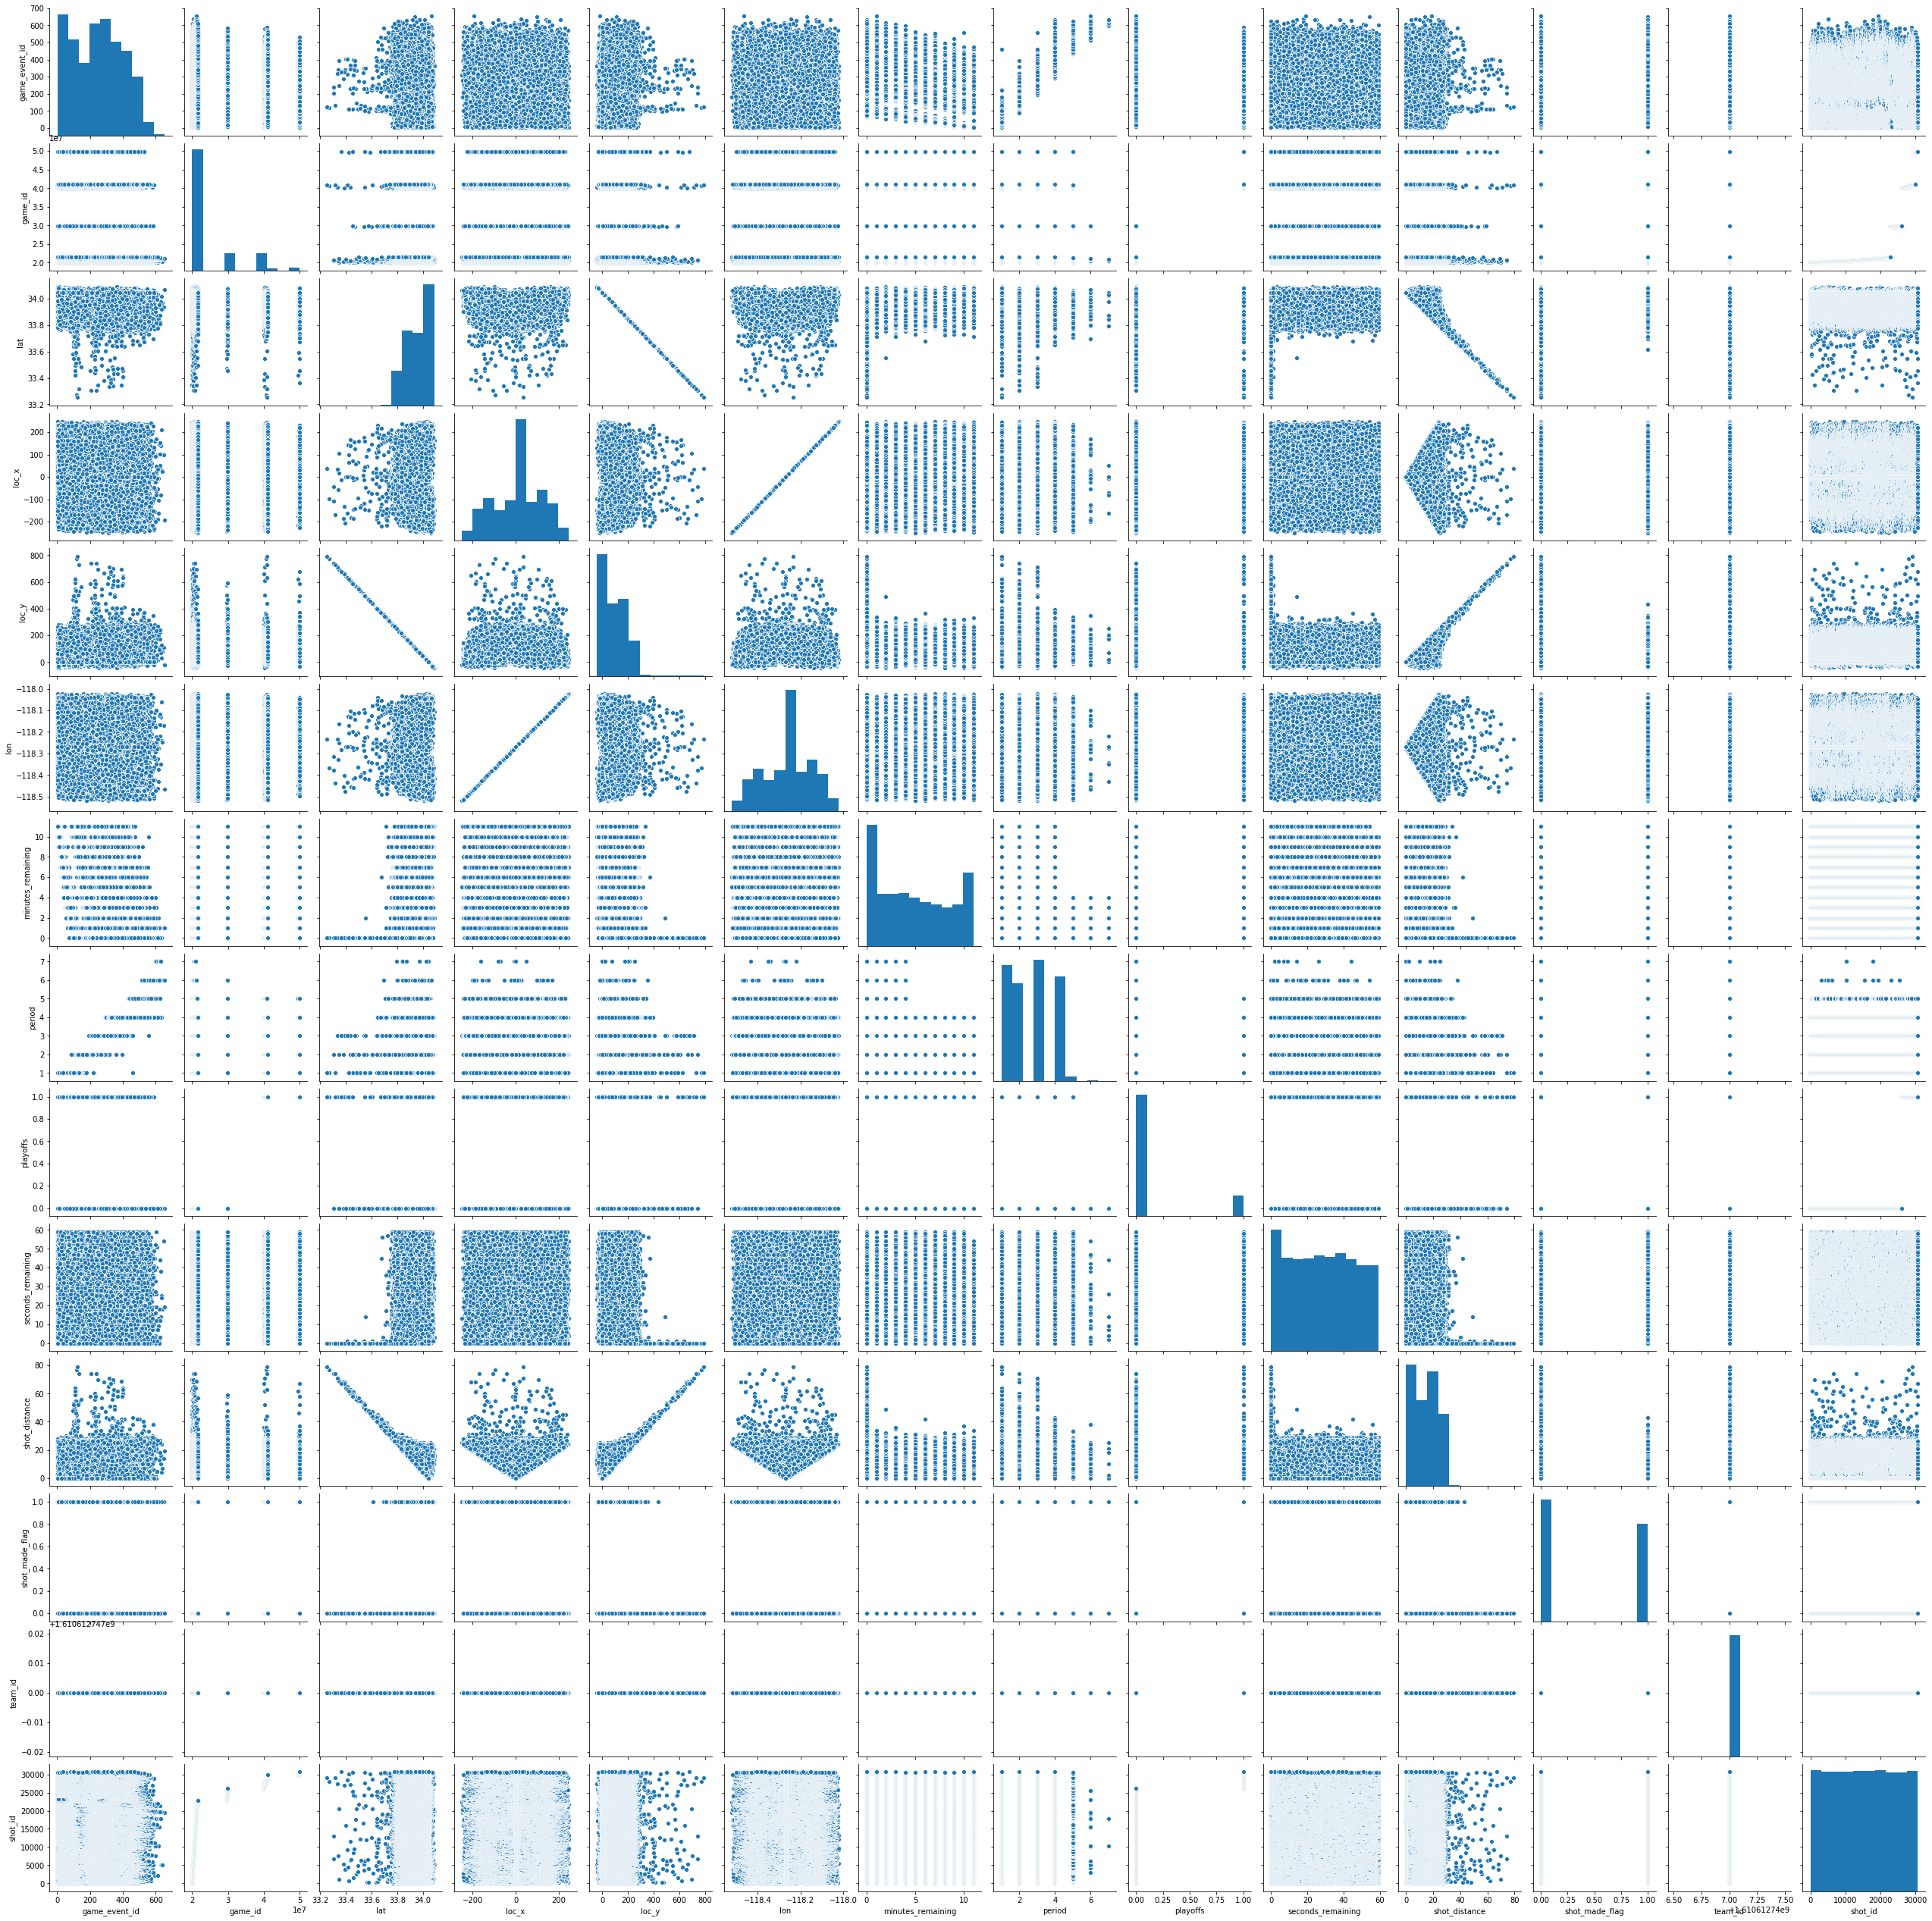

In [12]:
sns.pairplot(data)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [14]:
data_d = data
data_d = data_d.drop(['season',  'shot_made_flag', 'game_date', 'matchup'], axis = 1)



In [15]:
data['action_type'].unique()

array(['Jump Shot', 'Driving Dunk Shot', 'Layup Shot',
       'Running Jump Shot', 'Reverse Dunk Shot', 'Slam Dunk Shot',
       'Driving Layup Shot', 'Turnaround Jump Shot', 'Reverse Layup Shot',
       'Tip Shot', 'Running Hook Shot', 'Alley Oop Dunk Shot',
       'Dunk Shot', 'Alley Oop Layup shot', 'Running Dunk Shot',
       'Driving Finger Roll Shot', 'Running Layup Shot',
       'Finger Roll Shot', 'Fadeaway Jump Shot', 'Follow Up Dunk Shot',
       'Hook Shot', 'Turnaround Hook Shot', 'Jump Hook Shot',
       'Running Finger Roll Shot', 'Jump Bank Shot',
       'Turnaround Finger Roll Shot', 'Hook Bank Shot',
       'Driving Hook Shot', 'Running Tip Shot',
       'Running Reverse Layup Shot', 'Driving Finger Roll Layup Shot',
       'Fadeaway Bank shot', 'Pullup Jump shot', 'Finger Roll Layup Shot',
       'Turnaround Fadeaway shot', 'Driving Reverse Layup Shot',
       'Driving Slam Dunk Shot', 'Step Back Jump shot',
       'Turnaround Bank shot', 'Reverse Slam Dunk Shot',
   

In [16]:
data_d = pd.get_dummies(data_d, columns = [  'action_type', 'combined_shot_type',  
                                          'shot_type', 'shot_zone_area', 'opponent', 'shot_zone_basic', 
                                                    'shot_zone_range', 'team_name'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_d, target, test_size=0.3, random_state= 42)

In [ ]:
from sklearn.metrics import roc_auc_score

In [18]:
reg = LinearRegression().fit(X_train,y_train)
reg.score(X_test, y_test)

0.13306206788841912

In [49]:
roc_auc_score( y_test, reg.predict(X_test))  

0.6854869186823866

In [20]:
from sklearn.linear_model import  Lasso

In [38]:
las = Lasso().fit(X_train,y_train)
las.score(X_test, y_test)

0.017243371292729348

In [48]:
roc_auc_score( y_test, las.predict(X_test))  

0.5758990712598672

In [36]:
from sklearn.linear_model import Ridge

In [39]:
rid = LinearRegression().fit(X_train,y_train)
rid.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.20254e-19): result may not be accurate.
  overwrite_a=True).T


0.1342405024299197

In [47]:
roc_auc_score( y_test, rid.predict(X_test))  

0.6858759404738067

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 30)
XPCAreduced =pca.fit_transform(X_train)

In [79]:
XPCAreduced

array([[-3.55594578e+06, -7.78486020e+03, -2.66625510e+02, ...,
         1.64385621e-01,  3.05206471e-02,  7.97003612e-02],
       [ 5.14470719e+06, -6.27431894e+03, -4.25348619e+01, ...,
        -2.15871559e-01,  2.57591219e-01, -2.81636252e-01],
       [-3.65625923e+06, -6.15407142e+03, -2.12318033e+02, ...,
        -1.78609230e-02, -1.26103375e-01, -1.03163687e-01],
       ...,
       [-4.75575884e+06,  1.01966790e+04,  8.22262384e+01, ...,
         8.09101791e-02,  7.40150058e-02,  1.31433953e-01],
       [-3.65593081e+06, -6.63168504e+03, -2.56094405e+02, ...,
        -1.65815916e-01, -2.26344575e-01,  1.80791879e-01],
       [ 1.59439020e+07,  9.42658411e+02,  4.55875012e+01, ...,
         2.11515010e-01, -1.46477078e-01,  2.98299727e-01]])

In [80]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(XPCAreduced, y_train, test_size=0.3, random_state= 42)

In [81]:
reg_1 = LinearRegression().fit(X_train_1,y_train_1)
reg_1.score(X_test_1, y_test_1)

0.12886309382341254

In [82]:
roc_auc_score( y_test_1, reg_1.predict(X_test_1))  

0.6861154498253774